In [0]:
# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1)

import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


Using TensorFlow backend.


In [3]:
x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


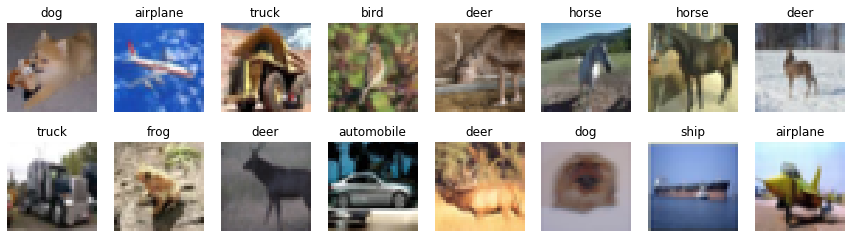

In [4]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [0]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5
# ### YOUR CODE HERE
y_train = keras.utils.to_categorical(y_train, num_classes=10)### YOUR CODE HERE

# x_val = ### YOUR CODE HERE
# y_val = ### YOUR CODE HERE
y_val = keras.utils.to_categorical(y_val, num_classes=10)### YOUR CODE HERE

# x_test = ### YOUR CODE HERE
# y_test = ### YOUR CODE HERE
y_test = keras.utils.to_categorical(y_test, num_classes=10)### YOUR CODE HERE

In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(10, (3, 3), padding='same', strides=3,
                     activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
#    ^^^^^^^^^^^ conv part 
 
#    ___________ FC part 
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10))  # the last layer with neuron for each class
    model.add(Activation("softmax"))  # output probabilities
    return model

In [8]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file
model.save_weights("weights.h5")







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 10000 samples
Epoch 1/10





40000/40000 [==============================] - 8s 192us/step - loss: 1.7367 - acc: 0.3719 - val_loss: 1.5144 - val_acc: 0.4674
Epoch 2/10
40000/40000 [==============================] - 7s 179us/step - loss: 1.4800 - acc: 0.4738 - val_loss: 1.3968 - val_acc: 0.5014
Epoch 3/10
40000/40000 [==============================] - 7s 175us/step - loss: 1.3926 - acc: 0.5041 - val_loss: 1.3411 - val_acc: 0.5212
Epoch 4/10
40000/40000 [==============================] - 7s 173us/step - loss: 1.3248 - acc: 0.5295 - val_loss: 1.3292 - val_acc: 0.5306
Epoch 5/10
40000/40000 [==============================] - 7s 175us/step - loss: 1.2831 - acc: 0.5454 - val_loss: 1.2682 - val_acc: 0.5518
Epoch 6/10
40000/40000 [===========

In [0]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

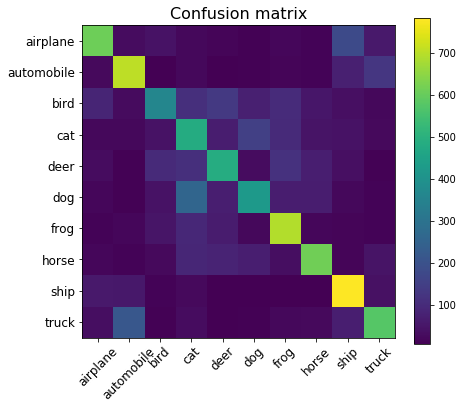

Test accuracy: 0.5731


In [10]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

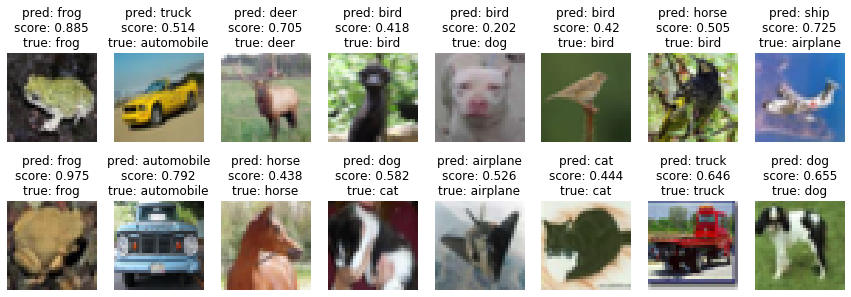

In [11]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

    "# Main: Quest For A Better Network\n",
    "\n",
    "(please read it at least diagonally)\n",
    "\n",
    "* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.\n",
    "* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.\n",
    " \n",
    "## Grading\n",
    "* starting at zero points\n",
    "* +2 for describing your iteration path in a report below.\n",
    "* +2 for building a network that gets above 20% accuracy\n",
    "* +1 for beating each of these milestones on __TEST__ dataset:\n",
    "    * 50% (5 total)\n",
    "    * 60% (6 total)\n",
    "    * 65% (7 total)\n",
    "    * 70% (8 total)\n",
    "    * 75% (9 total)\n",
    "    * 80% (10 total)\n",
    "    \n",
    "## Bonus points\n",
    "\n",
    "Common ways to get bonus points are:\n",
    "* Get higher score, obviously.\n",
    "* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.\n",
    "* Any detailed analysis of the results. (saliency maps, whatever)\n",
    "\n",
    "## Restrictions\n",
    "* Please do NOT use pre-trained networks for this assignment until you reach 80%.\n",
    " * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.\n",
    "* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.\n",
    "\n",
    "## Tips on what can be done:\n",
    "\n",
    "\n",
    " * __Network size__\n",
    "   * MOAR neurons, \n",
    "   * MOAR layers, ([lasagne docs](http://lasagne.readthedocs.org))\n",
    "\n",
    "   * Nonlinearities in the hidden layers\n",
    "     * tanh, relu, leaky relu, etc\n",
    "   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.\n",
    "\n",
    "   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!\n",
    "\n",
    " * __Convolution layers__\n",
    "   * they __are a must__ unless you have any super-ideas\n",
    "   * `network = lasagne.layers.Conv2DLayer(prev_layer,`\n",
    "    `                        num_filters = n_neurons,`\n",
    "    `                        filter_size = (filter width, filter height),`\n",
    "    `                        nonlinearity = some_nonlinearity)`\n",
    "   * Warning! Training convolutional networks can take long without GPU. That's okay.\n",
    "     * If you are CPU-only, we still recomment to try a simple convolutional architecture\n",
    "     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.\n",
    "     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.\n",
    "     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.\n",
    " \n",
    "   * Plenty other layers and architectures\n",
    "     * http://lasagne.readthedocs.org/en/latest/modules/layers.html\n",
    "     * batch normalization, pooling, etc\n",
    "\n",
    " * __Early Stopping__\n",
    "   * Training for 100 epochs regardless of anything is probably a bad idea.\n",
    "   * Some networks converge over 5 epochs, others - over 500.\n",
    "   * Way to go: stop when validation score is 10 iterations past maximum\n",
    "     \n",
    "\n",
    " * __Faster optimization__ - \n",
    "   * rmsprop, nesterov_momentum, adam, adagrad and so on.\n",
    "     * Converge faster and sometimes reach better optima\n",
    "     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs\n",
    "   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!\n",
    "\n",
    "\n",
    " * __Regularize__ to prevent overfitting\n",
    "   * Add some L2 weight norm to the loss function, theano will do the rest\n",
    "     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html\n",
    "   * Dropout - to prevent overfitting\n",
    "     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   \n",
    "     * Don't overdo it. Check if it actually makes your network better\n",
    "   \n",
    "   \n",
    " * __Data augmemntation__ - getting 5x as large dataset for free is a great deal\n",
    "   * Zoom-in+slice = move\n",
    "   * Rotate+zoom(to remove black stripes)\n",
    "   * any other perturbations\n",
    "   * Add Noize (easiest: GaussianNoizeLayer)\n",
    "   * Simple way to do that (if you have PIL/Image): \n",
    "     * ```from scipy.misc import imrotate,imresize```\n",
    "     * and a few slicing\n",
    "   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.\n",
    "   \n",
    "   \n",
    "   \n",
    "   \n",
    "   \n",
    " \n",
    " \n",
    "   \n",
    "There is a template for your solution below that you can opt to use or throw away and write it your way"

```
# This is formatted as code
```

